<a href="https://colab.research.google.com/github/Psubrat98/Assessment-Coding-Programs/blob/main/Autonomous_car_detection_with_yolov3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Object Detection with Yolov3**

Importing required dependencies

In [1]:
import struct
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import add, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from numpy import expand_dims

Loaing Yolov3 model

In [2]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/ML Project/Yolo/Yolov3/yolov3.h5')

In [3]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv_0 (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 bnorm_0 (BatchNormalization)   (None, None, None,   128         ['conv_0[0][0]']                 
                                32)                                                           

Make Prediction

In [4]:
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

In [12]:
IMAGE_WIDTH=416
IMAGE_HEIGHT=416
def load_and_preprocess_image(path,shape):
  image=tf.io.read_file(path)
  width,height=load_img(path).size
  image=tf.image.decode_jpeg(image,channels=3)
  image=tf.image.resize(image, shape)
  image/=255
  return image,width,height
     

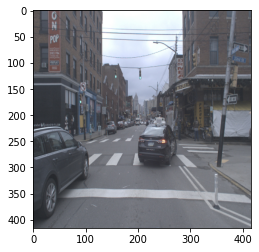

In [13]:
photo_filename='/content/drive/MyDrive/ML Project/ML & DL MODELS/DL Models/Autonomous car/Car dataset/ring_front_center_315978417021856392.jpg'
_image, image_w, image_h=load_and_preprocess_image(photo_filename,[IMAGE_WIDTH,IMAGE_HEIGHT])
plt.imshow(_image)

In [14]:
image = expand_dims(_image, 0)
yhat = model.predict(image)
print([a.shape for a in yhat])

1/1 [==============================] - 3s 3s/step
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


Process Output matrix

In [15]:
# This cell is based on https://machinelearningmastery.com/how-to-perform-object-detection-with-yolov3-in-keras/
class BoundBox:
	'''
	Objects of boxes. (xmin,ymin) represents the upleft coordinate of the box while (xmax,ymax) means downright one.
	'''
	def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.objness = objness
		self.classes = classes
		self.label = -1
		self.score = -1
 
	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)
 
		return self.label
 
	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]
 
		return self.score

def _sigmoid(x):
	return 1. / (1. + np.exp(-x))
 
def decode_netout(netout, anchors, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
 
	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 4th element is objectness score
			objectness = netout[int(row)][int(col)][b][4]
			# if(objectness.all() <= obj_thresh): continue
			# first 4 elements are x, y, w, and h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # center position, unit: image width
			y = (row + y) / grid_h # center position, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
			# last elements are class probabilities
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes

In [16]:
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
boxes = list()
for i in range(len(yhat)):
	boxes += decode_netout(yhat[i][0], anchors[i], net_h=IMAGE_HEIGHT, net_w=IMAGE_WIDTH)

for i in range(len(boxes)):
	x_offset, x_scale = (IMAGE_WIDTH - IMAGE_WIDTH)/2./IMAGE_HEIGHT, float(IMAGE_WIDTH)/IMAGE_WIDTH
	y_offset, y_scale = (IMAGE_HEIGHT - IMAGE_HEIGHT)/2./IMAGE_HEIGHT, float(IMAGE_HEIGHT)/IMAGE_HEIGHT
	boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
	boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
	boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
	boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [17]:
len(boxes)

10647

Box Filters

In [18]:
def box_filter(boxes,labels,threshold_socre):
	valid_boxes=[]
	valid_labels=[]
	valid_scores=[]
	for box in boxes:
		for i in range(len(labels)):
			if box.classes[i] > threshold_socre:
				valid_boxes.append(box)
				valid_labels.append(labels[i])
				valid_scores.append(box.classes[i])
		
	return (valid_boxes,valid_labels,valid_scores)

In [93]:
valid_data= box_filter(boxes, labels, threshold_socre=0.4)

Draw all Boxes

In [94]:
def draw_boxes(filename, valid_data):

	data = pyplot.imread(filename)
	pyplot.imshow(data)
	ax = pyplot.gca()
	for i in range(len(valid_data[0])):
		box = valid_data[0][i]
		y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
		width, height = x2 - x1, y2 - y1
		rect = Rectangle((x1, y1), width, height, fill=False, color='aqua')
		ax.add_patch(rect)
		print(valid_data[1][i], valid_data[2][i])
		label = "%s (%.3f)" % (valid_data[1][i], valid_data[2][i])
		pyplot.text(x1, y1, label, color='lime')
	pyplot.show()

car 0.9764872
car 0.9661045
car 0.9980663
car 0.9823238
car 0.80843246
car 0.9939055
car 0.96079546
car 0.5333438
car 0.9955249
car 0.91725576
traffic light 0.48811036
traffic light 0.8232706
car 0.43979317
car 0.7384737
car 0.47498938
car 0.5912507
car 0.47568172
car 0.802679
truck 0.4799342
car 0.9335093
car 0.7875544
car 0.84667146
car 0.6574391
car 0.88216454
car 0.5170529
car 0.9245942
car 0.6139586
car 0.97988105
car 0.9218586
person 0.964602
person 0.94654447


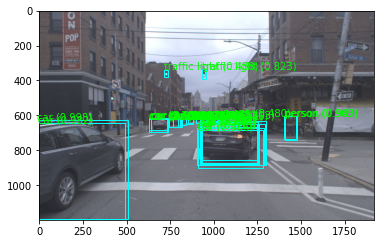

In [95]:
draw_boxes(photo_filename,valid_data)

Non-max Seppression, NMS

In [96]:
def encoder_dic(valid_data):
  data_dic={}
  (valid_boxes,valid_labels,valid_scores)=valid_data
  for box, label,score in zip(valid_boxes,valid_labels,valid_scores):
    if label not in data_dic:
      data_dic[label]=[[score,box,'kept']]
    else:
      data_dic[label].append([score,box,'kept'])
      
  return data_dic
dic=encoder_dic(valid_data)

In [97]:
def decode_box_coor(box):
  return (box.xmin, box.ymin,box.xmax, box.ymax )

def iou(box1, box2):
  (box1_x1, box1_y1, box1_x2, box1_y2) = decode_box_coor(box1)
  (box2_x1, box2_y1, box2_x2, box2_y2) = decode_box_coor(box2)

  xi1 = max(box1_x1,box2_x1)
  yi1 = max(box1_y1,box2_y1)
  xi2 = min(box1_x2,box2_x2)
  yi2 = min(box1_y2,box2_y2)
  inter_width = xi2-xi1
  inter_height = yi2-yi1
  inter_area = max(inter_height,0)*max(inter_width,0)

  box1_area = (box1_x2-box1_x1)*(box1_y2-box1_y1)
  box2_area = (box2_x2-box2_x1)*(box2_y2-box2_y1)
  union_area = box1_area+box2_area-inter_area 

  iou = inter_area/union_area
  
  return iou

def do_nms(data_dic, nms_thresh):
  final_boxes,final_scores,final_labels=list(),list(),list()
  for label in data_dic:
    scores_boxes=sorted(data_dic[label],reverse=True)
    for i in range(len(scores_boxes)):
      if scores_boxes[i][2]=='removed': continue
      for j in range(i+1,len(scores_boxes)):
        if iou(scores_boxes[i][1],scores_boxes[j][1]) >= nms_thresh:
          scores_boxes[j][2]="removed"

    for e in scores_boxes:
      print(label+' '+str(e[0]) + " status: "+ e[2])
      if e[2]=='kept':
        final_boxes.append(e[1])
        final_labels.append(label)
        final_scores.append(e[0])
    

  return (final_boxes,final_labels,final_scores)

In [98]:
final_data=do_nms(dic, 0.7)

car 0.9980663 status: kept
car 0.9955249 status: kept
car 0.9939055 status: removed
car 0.9823238 status: removed
car 0.97988105 status: kept
car 0.9764872 status: removed
car 0.9661045 status: removed
car 0.96079546 status: removed
car 0.9335093 status: removed
car 0.9245942 status: kept
car 0.9218586 status: removed
car 0.91725576 status: removed
car 0.88216454 status: kept
car 0.84667146 status: kept
car 0.80843246 status: removed
car 0.802679 status: kept
car 0.7875544 status: removed
car 0.7384737 status: kept
car 0.6574391 status: removed
car 0.6139586 status: kept
car 0.5912507 status: kept
car 0.5333438 status: removed
car 0.5170529 status: kept
car 0.47568172 status: kept
car 0.47498938 status: kept
car 0.43979317 status: kept
traffic light 0.8232706 status: kept
traffic light 0.48811036 status: kept
truck 0.4799342 status: kept
person 0.964602 status: kept
person 0.94654447 status: removed


car 0.9980663
car 0.9955249
car 0.97988105
car 0.9245942
car 0.88216454
car 0.84667146
car 0.802679
car 0.7384737
car 0.6139586
car 0.5912507
car 0.5170529
car 0.47568172
car 0.47498938
car 0.43979317
traffic light 0.8232706
traffic light 0.48811036
truck 0.4799342
person 0.964602


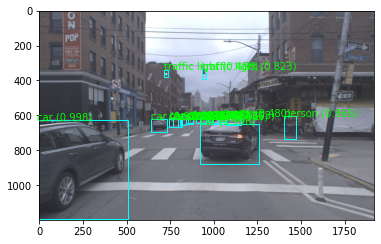

In [99]:
draw_boxes(photo_filename,final_data)

Use Keras "non_max_suppression

In [100]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    nms_indices = tf.image.non_max_suppression(scores=scores,boxes=boxes,max_output_size=max_boxes,iou_threshold=iou_threshold)

    scores = K.gather(scores,nms_indices)
    boxes = K.gather(boxes,nms_indices)
    classes = K.gather(classes,nms_indices)

    return scores, boxes, classes

Other Results

In [101]:
def showresults(path):
  _image,width,height=load_and_preprocess_image(path,[IMAGE_WIDTH,IMAGE_HEIGHT])
  image = expand_dims(_image, 0)
  yhat = model.predict(image)
  boxes = list()
  for i in range(len(yhat)):
	  boxes += decode_netout(yhat[i][0], anchors[i], net_h=IMAGE_HEIGHT, net_w=IMAGE_WIDTH)
  for i in range(len(boxes)):
    x_offset, x_scale = (IMAGE_WIDTH - IMAGE_WIDTH)/2./IMAGE_HEIGHT, float(IMAGE_WIDTH)/IMAGE_WIDTH
    y_offset, y_scale = (IMAGE_HEIGHT - IMAGE_HEIGHT)/2./IMAGE_HEIGHT, float(IMAGE_HEIGHT)/IMAGE_HEIGHT
    boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
    boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
    boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
    boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
  valid_data= box_filter(boxes, labels, threshold_socre=0.6)
  dic=encoder_dic(valid_data)
  final_data=do_nms(dic, 0.7)
  draw_boxes(path,final_data)

In [102]:
def detect_object(path):
  from PIL import Image
  img_path = path
  image = Image.open(img_path)
  new_img = image.resize((1920, 1200))
  new_image = new_img.save('myimage.jpg')
  return showresults('myimage.jpg')

1/1 [==============================] - 2s 2s/step
person 0.9976688 status: kept
person 0.99606067 status: kept
person 0.99344665 status: kept
person 0.9909767 status: kept
person 0.9880732 status: removed
person 0.9821962 status: kept
person 0.9724139 status: removed
person 0.9631647 status: kept
person 0.9609885 status: kept
person 0.9451294 status: removed
person 0.94428813 status: removed
person 0.9304793 status: removed
person 0.9284415 status: kept
person 0.92580515 status: removed
person 0.90016335 status: removed
person 0.8972006 status: removed
person 0.88522536 status: removed
person 0.86875737 status: kept
person 0.8355234 status: removed
person 0.7565071 status: kept
person 0.74335366 status: removed
person 0.7291143 status: kept
person 0.6951257 status: kept
person 0.6877036 status: removed
person 0.6515677 status: removed
person 0.65111333 status: removed
person 0.6422631 status: removed
person 0.62586665 status: removed
person 0.6136855 status: kept
person 0.9976688
perso

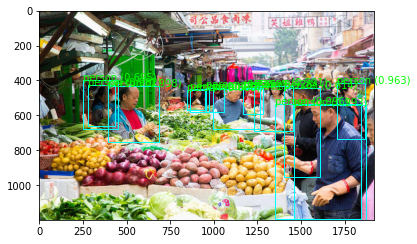

In [103]:
detect_object('/content/drive/MyDrive/ML Project/ML & DL MODELS/DL Models/Autonomous car/traffic and road/market_large_354703739_1000.jpg')

1/1 [==============================] - 1s 1s/step
car 0.7179877 status: kept
car 0.6936175 status: removed
car 0.6136106 status: removed
truck 0.93556297 status: kept
truck 0.732266 status: removed
truck 0.69380254 status: removed
person 0.99018997 status: kept
person 0.98136526 status: removed
person 0.91936445 status: kept
person 0.78475636 status: kept
person 0.7382825 status: removed
person 0.69040847 status: kept
person 0.6880713 status: removed
person 0.68629533 status: removed
person 0.60511327 status: removed
car 0.7179877
truck 0.93556297
person 0.99018997
person 0.91936445
person 0.78475636
person 0.69040847


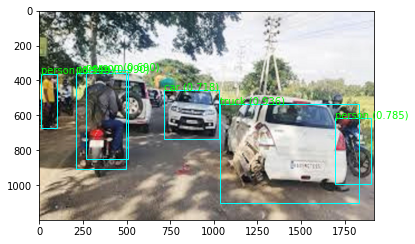

In [104]:
detect_object('/content/drive/MyDrive/ML Project/ML & DL MODELS/DL Models/Autonomous car/traffic and road/images.jpg')

1/1 [==============================] - 1s 1s/step
person 0.9979878 status: kept
person 0.99778056 status: kept
person 0.9971907 status: kept
person 0.99676776 status: removed
person 0.9956389 status: kept
person 0.99233335 status: removed
person 0.9859742 status: removed
person 0.98533165 status: removed
person 0.9575657 status: removed
person 0.95290166 status: removed
person 0.93996596 status: removed
person 0.9380776 status: removed
cell phone 0.9625966 status: kept
cell phone 0.6156077 status: removed
cell phone 0.6036627 status: removed
book 0.92051667 status: kept
cup 0.8783828 status: kept
cup 0.84173876 status: kept
cup 0.83162135 status: removed
cup 0.81530535 status: removed
person 0.9979878
person 0.99778056
person 0.9971907
person 0.9956389
cell phone 0.9625966
book 0.92051667
cup 0.8783828
cup 0.84173876


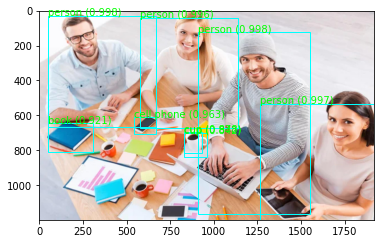

In [105]:
detect_object('/content/drive/MyDrive/ML Project/ML & DL MODELS/DL Models/Autonomous car/Other/depositphotos_71832381-stock-photo-business-people-working-together.jpg')

1/1 [==============================] - 1s 1s/step
bird 0.9916159 status: kept
bird 0.98581886 status: kept
bird 0.9791141 status: removed
bird 0.94000757 status: kept
bird 0.9388024 status: kept
bird 0.91948694 status: removed
bird 0.91847783 status: kept
bird 0.9165664 status: kept
bird 0.87274814 status: removed
bird 0.8684207 status: removed
bird 0.8518504 status: removed
bird 0.8254799 status: removed
bird 0.82335734 status: removed
bird 0.742355 status: removed
bird 0.7374614 status: kept
bird 0.7258068 status: kept
bird 0.71660954 status: removed
bird 0.70449823 status: kept
bird 0.6924936 status: removed
bird 0.6599961 status: removed
bird 0.6522998 status: removed
bird 0.6499802 status: removed
person 0.71515346 status: kept
bird 0.9916159
bird 0.98581886
bird 0.94000757
bird 0.9388024
bird 0.91847783
bird 0.9165664
bird 0.7374614
bird 0.7258068
bird 0.70449823
person 0.71515346


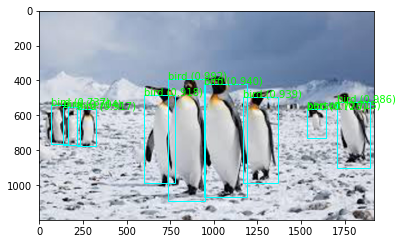

In [106]:
detect_object('/content/drive/MyDrive/ML Project/ML & DL MODELS/DL Models/Autonomous car/Other/penguin-images (2).jpg')

1/1 [==============================] - 1s 1s/step
elephant 0.93030834 status: kept
elephant 0.7730508 status: removed
elephant 0.633935 status: removed
elephant 0.93030834


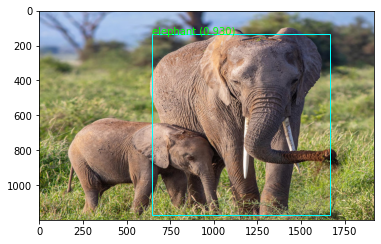

In [107]:
detect_object('/content/drive/MyDrive/ML Project/ML & DL MODELS/DL Models/Autonomous car/Other/photo-1592670130429-fa412d400f50.jpg')